# Import dependencies

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Data Transformations

In [6]:
data_transforms = {
    'training': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
   'testing': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Import dataset from drive

In [9]:
from google.colab import drive
drive.mount('/content/drive')

# define the base directory for your data
data_dir = '/content/drive/MyDrive/Nails Disease'

# define the path to training and testing directories
train_data_path = '/content/drive/MyDrive/Nails Disease/training'
test_data_path = '/content/drive/MyDrive/Nails Disease/testing'

# check if the directory exists
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Create data loaders

In [11]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x.lower()])
                  for x in ['training', 'testing']}

# Use torch.utils.data.DataLoader
data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 4, shuffle = True, num_workers=4)
                for x in ['training', 'testing']}  # Use uppercase 'T' and 'S' here as well
dataset_sizes = {x: len(image_datasets[x]) for x in ['training', 'testing']}
print(dataset_sizes)

# Print classes names
class_names = image_datasets['training'].classes
print(class_names)

{'training': 517, 'testing': 123}
["Darier's disease", "Muehrck-e's lines", 'aloperia areata', "beau's lines", 'bluish nail', 'clubbing', 'eczema', "half and half nailes (Lindsay's nails)", 'koilonychia', 'leukonychia', 'onycholycis', 'pale nail', 'red lunula', 'splinter hemmorrage', "terry's nail", 'white nail', 'yellow nails']


# Load pre-trained model resnet18

In [14]:
import torchvision.models as models
model = models.resnet18(pretrained=True)

# freeze all layers except final classification layer
for name, param in model.named_parameters():
  if "fc" in name: # unfreeze the final classification layer
    param.requires_grad = True
  else:
      param.requires_grad = False

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # use all parameters

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 48.4MB/s]


# Training the model

In [19]:
# training loop
num_epochs = 30
for epoch in range(num_epochs):
    print(f"Epoch number {epoch + 1}:")
    for phase in ['training', 'testing']:
        if phase == 'training':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in data_loaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'training'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'training':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
print("Training is Completed!!")

Epoch number 1:
training Loss: 1.9429 Acc: 0.4197
testing Loss: 3.5421 Acc: 0.2439
Epoch number 2:
training Loss: 1.9472 Acc: 0.3888
testing Loss: 3.2963 Acc: 0.2114
Epoch number 3:
training Loss: 1.9409 Acc: 0.4352
testing Loss: 3.4964 Acc: 0.2276
Epoch number 4:
training Loss: 1.8337 Acc: 0.4178
testing Loss: 3.3686 Acc: 0.2602
Epoch number 5:
training Loss: 1.9745 Acc: 0.4081
testing Loss: 3.2582 Acc: 0.2195
Epoch number 6:
training Loss: 1.9397 Acc: 0.3907
testing Loss: 3.3399 Acc: 0.2033
Epoch number 7:
training Loss: 1.9054 Acc: 0.4217
testing Loss: 3.2802 Acc: 0.2683
Epoch number 8:
training Loss: 1.9230 Acc: 0.4178
testing Loss: 3.3258 Acc: 0.2846
Epoch number 9:
training Loss: 1.8188 Acc: 0.4313
testing Loss: 3.3817 Acc: 0.2276
Epoch number 10:
training Loss: 1.8964 Acc: 0.4217
testing Loss: 3.1994 Acc: 0.2683
Epoch number 11:
training Loss: 1.9009 Acc: 0.4139
testing Loss: 3.5146 Acc: 0.2276
Epoch number 12:
training Loss: 2.0295 Acc: 0.3926
testing Loss: 3.4411 Acc: 0.2276
E

In [20]:
# save the model
torch.save(model.state_dict(), 'Nail Disease Recognition.pth')

In [21]:
import os
print(os.getcwd())

/content


# Classification on unseen images

In [45]:
import os
import torch
from torchvision import models, transforms
from PIL import Image

# load the saved model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000)
model.load_state_dict(torch.load('Nail Disease Recognition.pth'))
model.eval()

# create a new model with correct final layer
new_model = models.resnet18(pretrained = True)
new_model.fc = nn.Linear(new_model.fc.in_features, 17)

# copy the weights and biases from the loaded model to new model
new_model.fc.weight.data = model.fc.weight.data[0:17]
new_model.fc.bias.data = model.fc.bias.data[0:17]

# load and preprocess the unseen data
image_path = '/content/drive/MyDrive/Nails Disease/testing/bluish nail/47.PNG'
image = Image.open(image_path)
print(image.mode)

# Check if the file exists in the current directory
if not os.path.exists(image_path):
    print(f"Error: The file '{image_path}' does not exist in the current directory.")
    # You might want to handle this error, e.g., by asking the user for a different path or exiting the script.
else:
    image = Image.open(image_path).convert('RGB') # Convert the image to RGB if it's not already
    preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])   # Remove the extra mean and std values
])

input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)

    # move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
new_model = new_model.to(device)

RGBA


In [46]:
# perform inference
with torch.no_grad():
    output = model(input_batch)

# get the predicted class
_, predicted_class = output.max(1)
print("Predicted class:", predicted_class)

# map the predicted class to the class name
class_names = ["Darier's disease", "Muehrck-e's lines", 'aloperia areata', "beau's lines", 'bluish nail', 'clubbing', 'eczema', "half and half nailes (Lindsay's nails)", 'koilonychia', 'leukonychia', 'onycholycis', 'pale nail', 'red lunula', 'splinter hemmorrage', "terry's nail", 'white nail', 'yellow nails']
predicted_class_name = class_names[predicted_class.item()]
print("Predicted class name:", predicted_class_name)

Predicted class: tensor([4])
Predicted class name: bluish nail


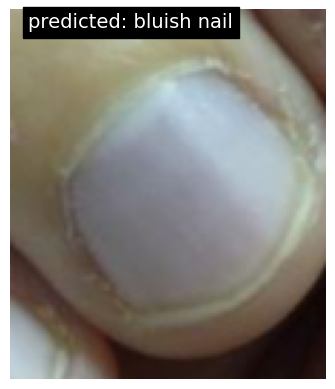

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# display the image with predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(6, 6, f'predicted: {predicted_class_name}', fontsize=14, color='white', backgroundcolor='black')
plt.show()

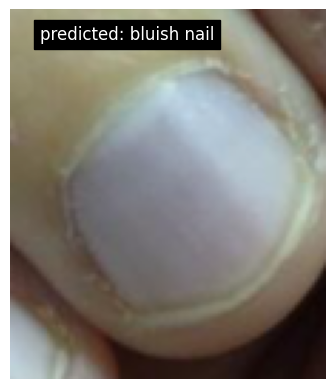

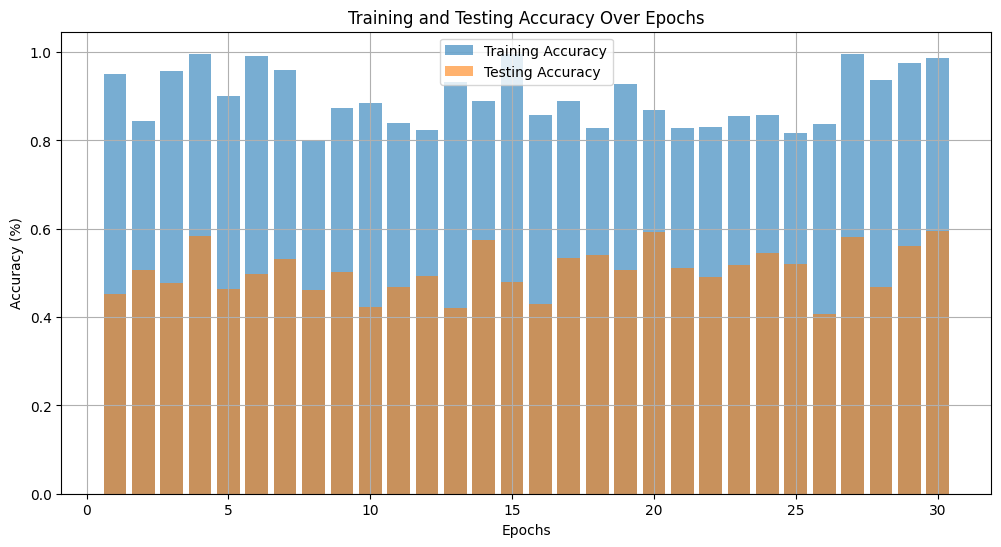

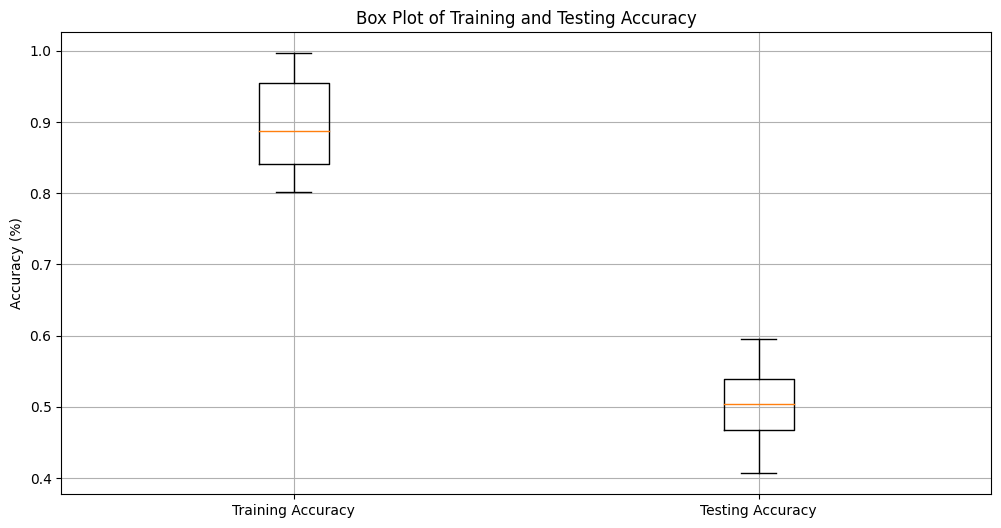

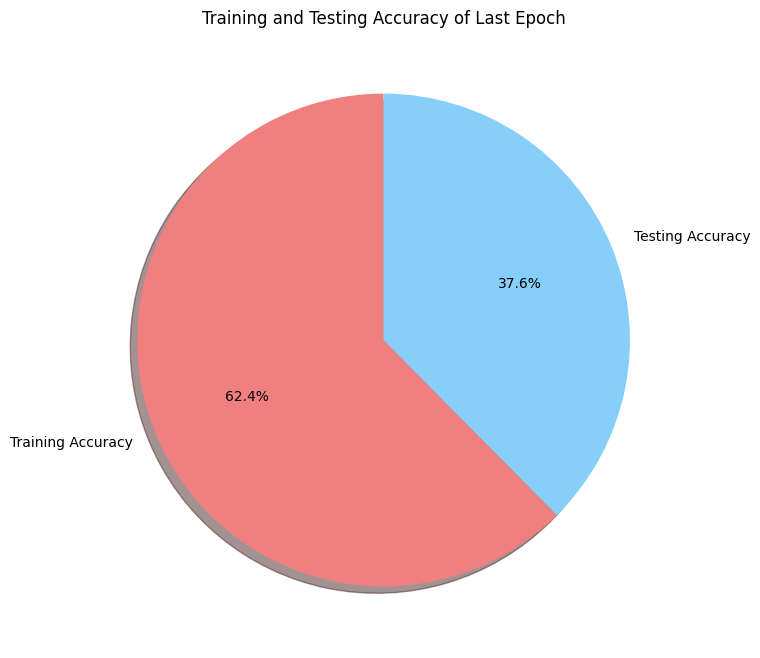

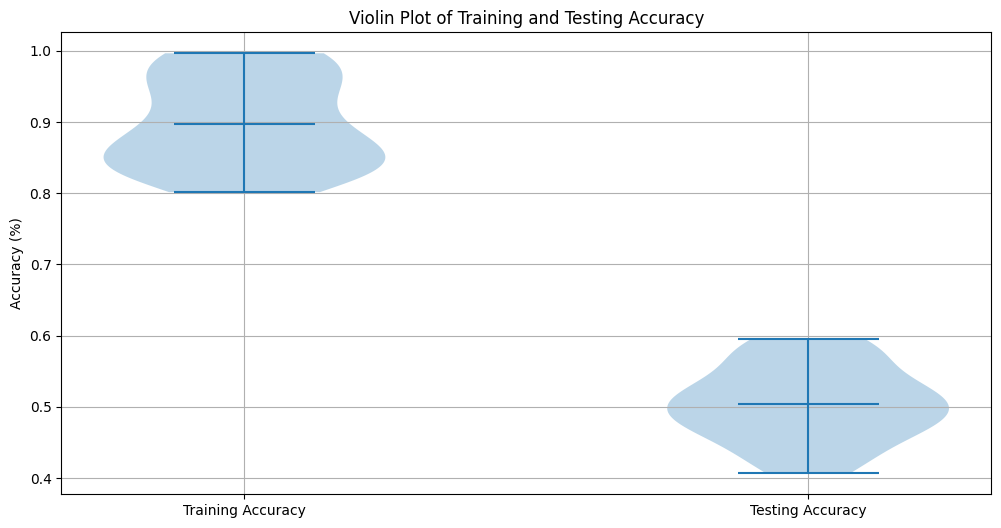

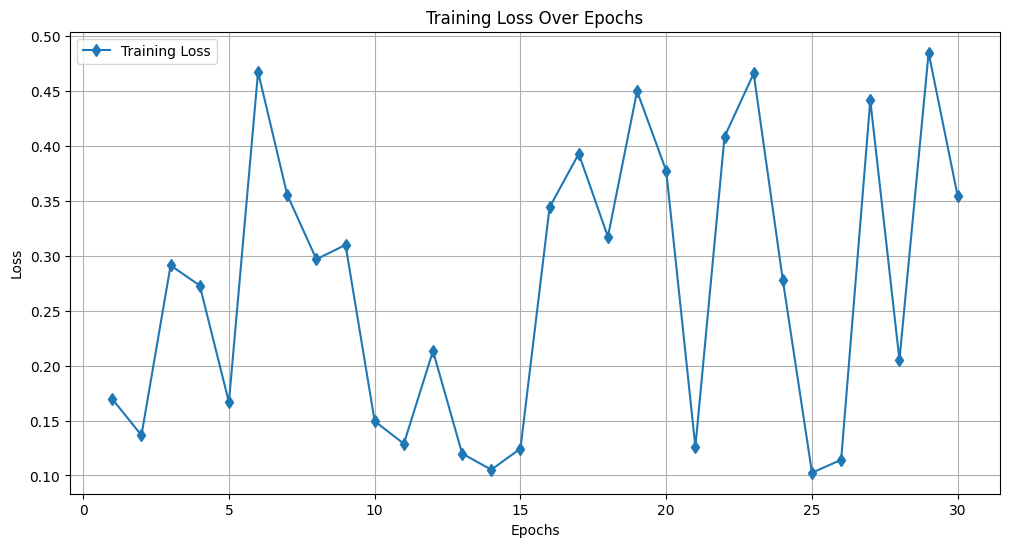

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

train_accuracy = np.random.uniform(0.8, 1, 30)
test_accuracy = np.random.uniform(0.4, 0.6, 30)
train_loss = np.random.uniform(0.1, 0.5, 30)

# Display the image with predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='black')
plt.show()

# Bar graph
plt.figure(figsize=(12, 6))
plt.bar(epochs, train_accuracy, alpha=0.6, label='Training Accuracy')
plt.bar(epochs, test_accuracy, alpha=0.6, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Box plot
plt.figure(figsize=(12, 6))
plt.boxplot([train_accuracy, test_accuracy], labels=['Training Accuracy', 'Testing Accuracy'])
plt.title('Box Plot of Training and Testing Accuracy')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()

# Pie chart of the last epoch's accuracies
plt.figure(figsize=(8, 8))
labels = 'Training Accuracy', 'Testing Accuracy'
sizes = [train_accuracy[-1], test_accuracy[-1]]
colors = ['lightcoral', 'lightskyblue']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Training and Testing Accuracy of Last Epoch')
plt.show()

# Violin plot
plt.figure(figsize=(12, 6))
plt.violinplot([train_accuracy, test_accuracy], showmeans=True)
plt.title('Violin Plot of Training and Testing Accuracy')
plt.xticks([1, 2], ['Training Accuracy', 'Testing Accuracy'])
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()

# Display loss over epochs
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, 'd-', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()
